<a href="https://www.kaggle.com/code/irynabarnych/ai15-lab?scriptVersionId=171401310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Завдання:
Ознайомитись з даними та структурою даних
Створіть доповнення(transform) для тренувальних та тестових даних. посилання
Створіть train_dataset та test_dataset за допомогою ImageFolder(може знадобитись ConcatDataset
Створіть train_dataset та test_dataset за допомогою власно написаного Dataset
Візуалізуйте дані
Збережіть kaggle notebook для подальшої роботи

In [34]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])



In [36]:

# Створити екземпляр ImageFolder з трансформаціями
dataset0 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0")
dataset1 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1")
dataset2 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2")
dataset0.classes

['all', 'hem']

In [37]:
dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset0])

In [38]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [40]:
import os
from PIL import Image


class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None, task='Train'):
        """
        Args:
          root_dir (str): Path to the directory containing images.
          transform (torchvision.transforms, optional): Transformations to apply to images. Defaults to None.
        """
        self.root_dir = root_dir
        self.image_paths = self.get_pathes(root_dir, task)

        self.classes = os.listdir(root_dir)
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}
        self.transform = transform

    def get_pathes(self, root, task):
        image_paths = []
        labels = os.listdir(root)

        for label in labels:
            images = os.listdir(os.path.join(root, label, task))    
            image_paths.extend([os.path.join(root, label, task, image) for image in images])
        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        label_name = os.path.normpath(image_path).split(os.path.sep)[-3]

        return image, self.class_to_idx[label_name]

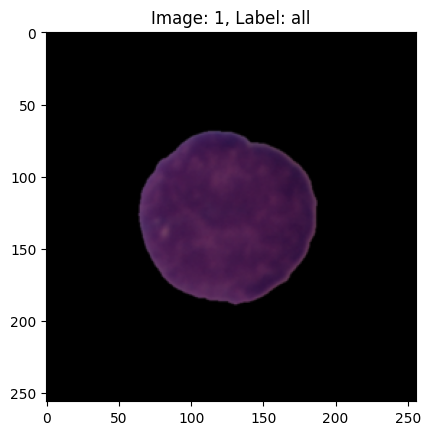

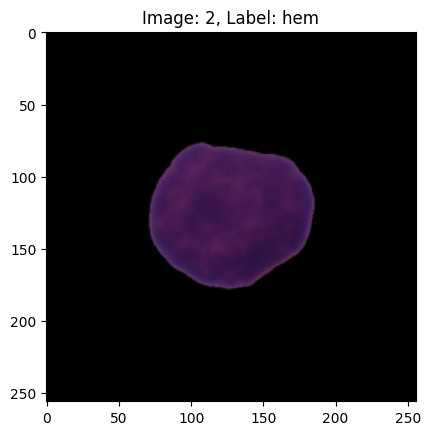

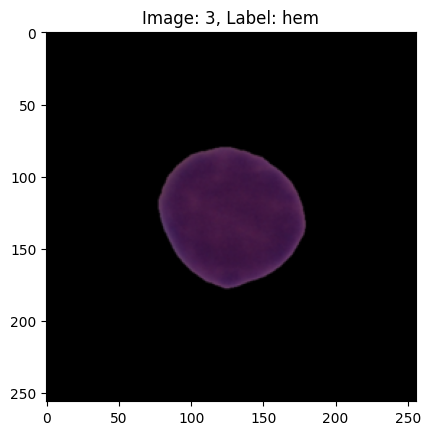

In [41]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = dataset0.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

In [42]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0) # результатом є тензор

plt.imshow(grid)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>